In [2]:
import tensorflow as tf

2025-05-16 11:33:58.922999: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 11:33:58.923814: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-16 11:33:58.928222: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-16 11:33:58.939885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747388038.962079    7034 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747388038.96

In [3]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = (train_images.astype("float32") - 127.5) / 127.5
train_images = tf.expand_dims(train_images, -1)
train_data = tf.data.Dataset.from_tensor_slices(train_images).shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)

2025-05-16 11:34:01.165342: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [1]:
from tensorflow.keras import layers, models, losses, metrics


# === 2. DISCRIMINATOR ===
def build_discriminator():
    inp = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, 5, strides=2, padding='same')(inp)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, 5, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)  # No sigmoid, logits output
    return models.Model(inp, x, name="Discriminator")


# === 3. GENERATOR ===
def build_generator(latent_dim=100):
    inp = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, use_bias=False)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 128))(x)

    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, 4, strides=2, padding='same', activation='tanh')(x)
    return models.Model(inp, x, name="Generator")

# === 4. DCGAN TRAINING ===
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim, label_flipping_rate=0.0):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.label_flipping_rate = label_flipping_rate

    def compile(self, d_optimizer, g_optimizer):
        super().compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent = tf.random.normal((batch_size, self.latent_dim))

        # === DISCRIMINATOR TRAINING ===
        with tf.GradientTape() as d_tape:
            fake_images = self.generator(random_latent, training=True)
            real_preds = self.discriminator(real_images, training=True)
            fake_preds = self.discriminator(fake_images, training=True)

            # Smoothed labels + noise
            real_labels = tf.random.uniform(tf.shape(real_preds), minval=0.9, maxval=1.0)
            fake_labels = tf.random.uniform(tf.shape(fake_preds), minval=0.0, maxval=0.1)

            # === LABEL FLIPPING ===
            if self.label_flipping_rate > 0.0:
                real_flip_mask = tf.random.uniform(tf.shape(real_labels)) < self.label_flipping_rate
                fake_flip_mask = tf.random.uniform(tf.shape(fake_labels)) < self.label_flipping_rate
                real_labels = tf.where(real_flip_mask, tf.zeros_like(real_labels), real_labels)
                fake_labels = tf.where(fake_flip_mask, tf.ones_like(fake_labels), fake_labels)

            d_real_loss = self.loss_fn(real_labels, real_preds)
            d_fake_loss = self.loss_fn(fake_labels, fake_preds)
            d_loss = 0.5 * (d_real_loss + d_fake_loss)

        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # === GENERATOR TRAINING ===
        with tf.GradientTape() as g_tape:
            fake_images = self.generator(random_latent, training=True)
            fake_preds = self.discriminator(fake_images, training=False)
            g_loss = self.loss_fn(tf.ones_like(fake_preds), fake_preds)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


2025-06-03 09:06:38.595526: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-03 09:06:38.596230: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 09:06:38.598724: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 09:06:38.605226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748934398.616211   12981 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748934398.61

2025-06-03 09:06:41.560169: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


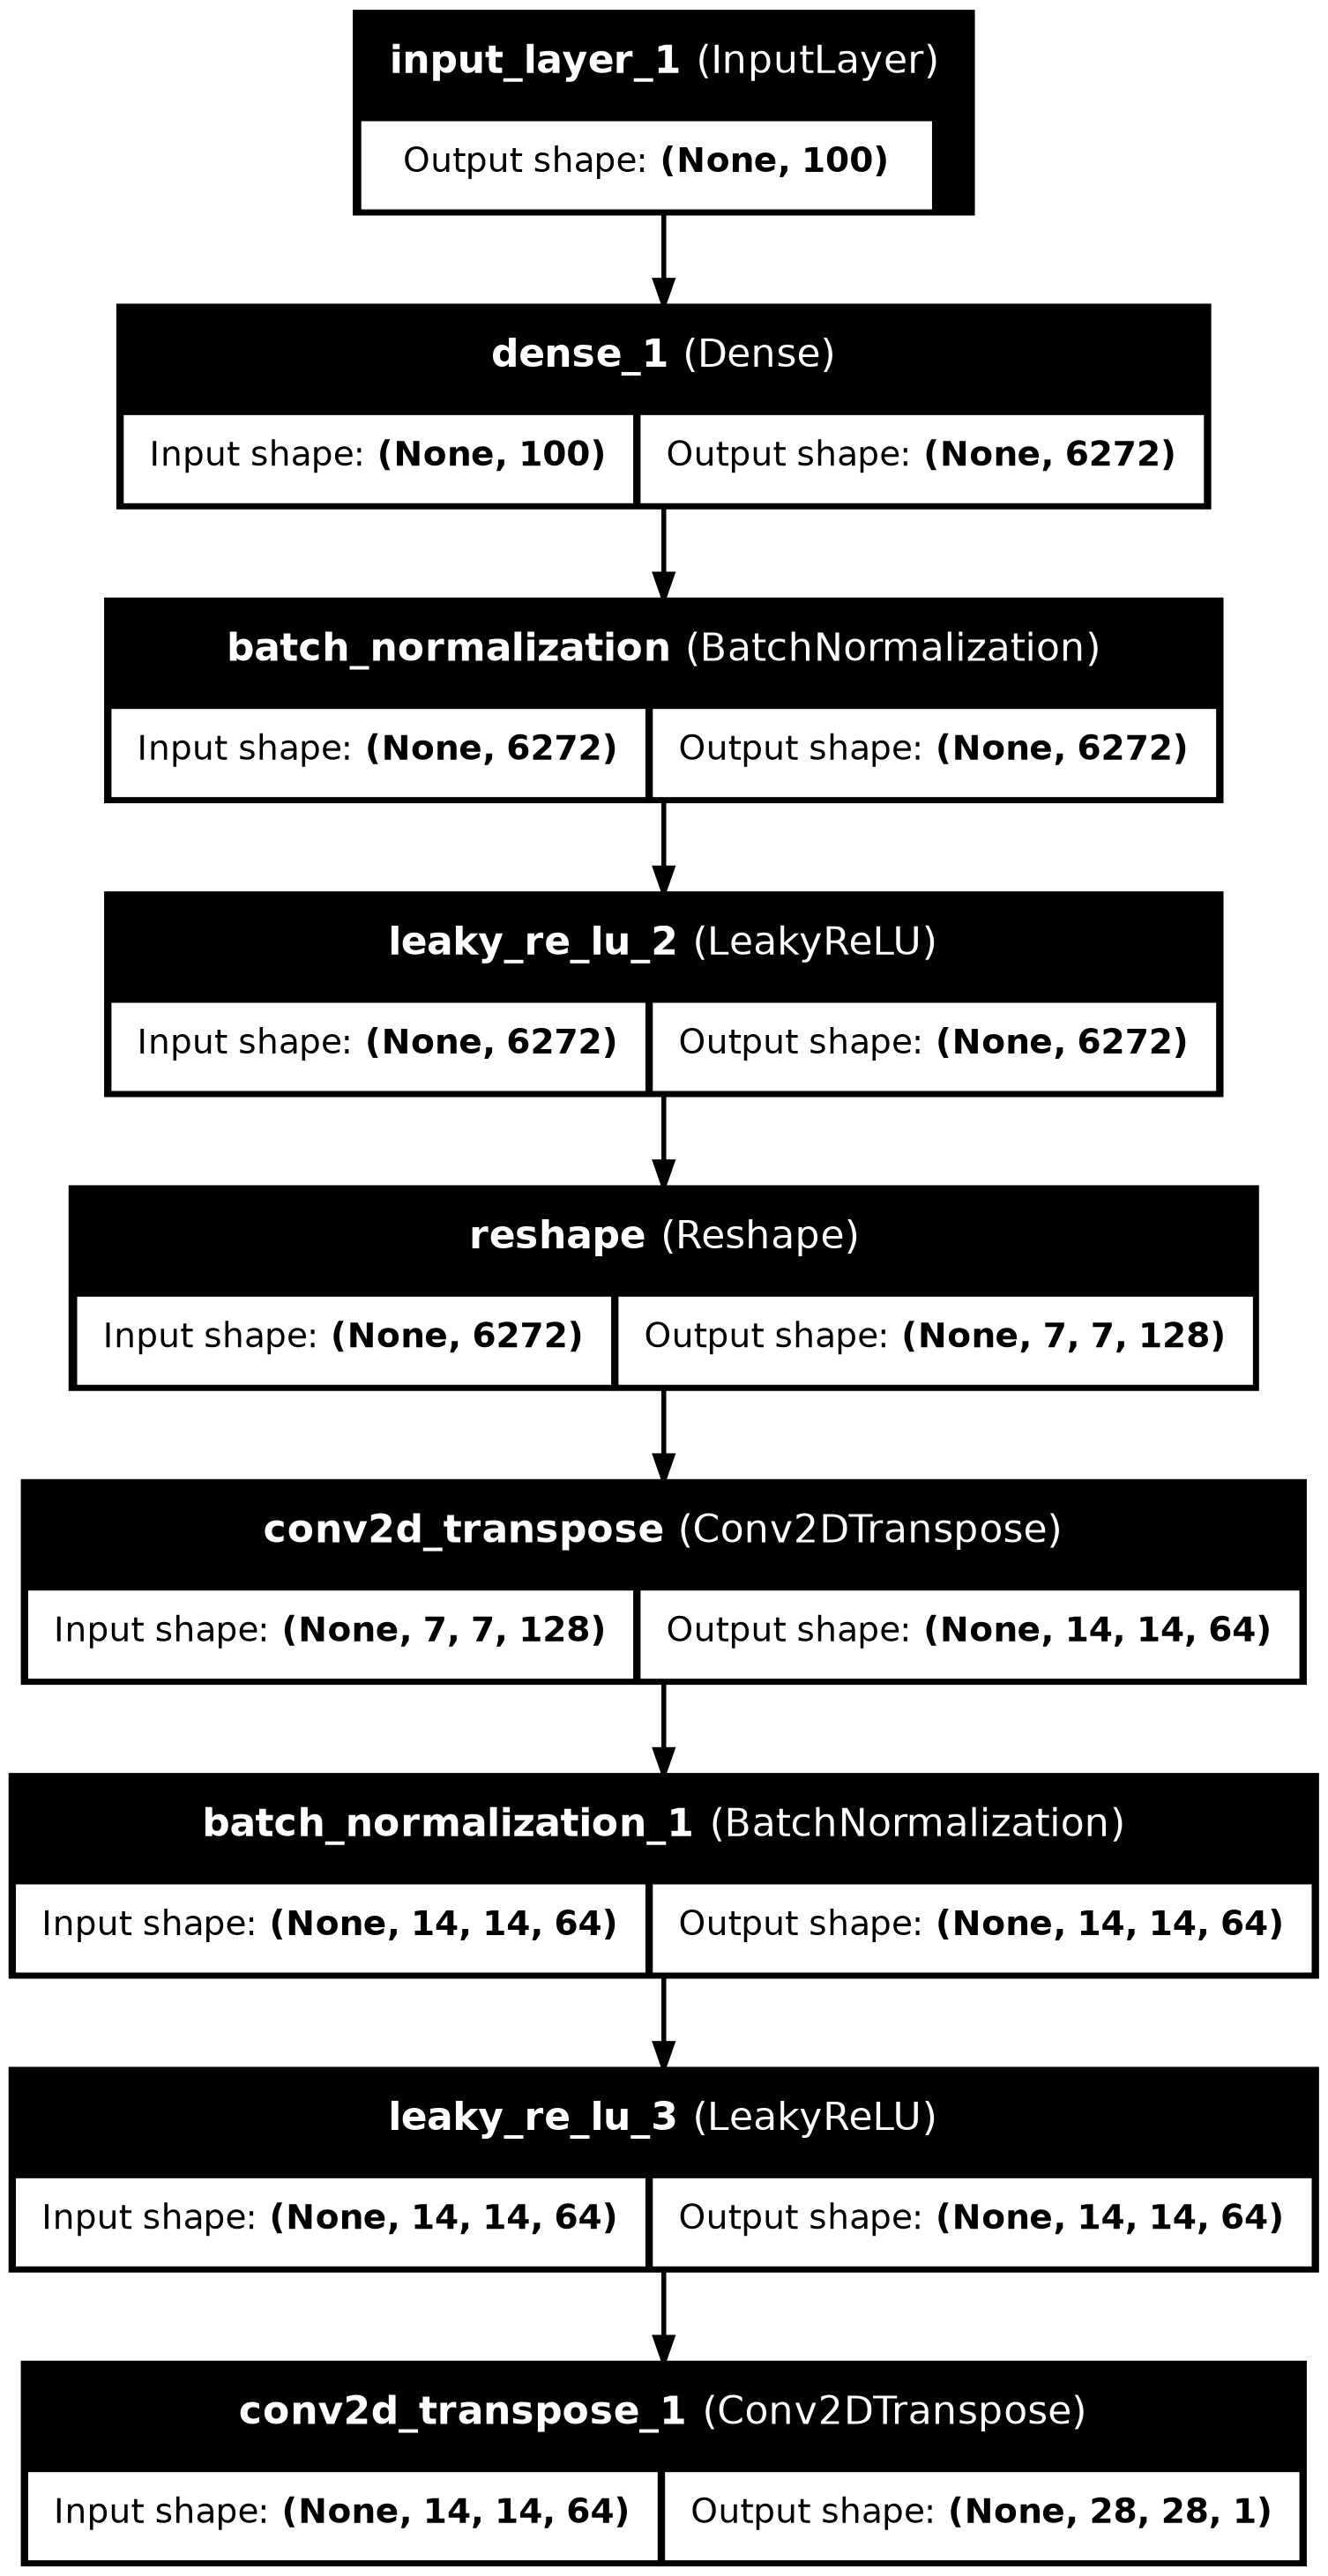

In [2]:
from tensorflow.keras.utils import plot_model
discriminator = build_discriminator()
generator = build_generator(latent_dim=100)
# Save model architecture diagrams to files
plot_model(discriminator, to_file="discriminator.png", show_shapes=True, show_layer_names=True)
plot_model(generator, to_file="generator.png", show_shapes=True, show_layer_names=True)


In [3]:
discriminator.summary()

print("\n=== Generator Architecture ===")
generator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)


=== Generator Architecture ===


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6272)           │       627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         1,025 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 784,641 (2.99 MB)

 Trainable params: 771,969 (2.94 MB)

 Non-trainable params: 12,672 (49.50 KB)

In [5]:
import matplotlib.pyplot as plt

In [6]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_images=5, latent_dim=100, exp_name="default"):
        super().__init__()
        self.num_images = num_images
        self.latent_dim = latent_dim
        self.exp_name = exp_name

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            z = tf.random.normal((self.num_images, self.latent_dim))
            generated = self.model.generator(z, training=False)
            imgs = (generated * 127.5 + 127.5) / 255.0

            # Create subfolder for this experiment
            save_dir = os.path.join("generated", self.exp_name)
            os.makedirs(save_dir, exist_ok=True)
            image_path = os.path.join(save_dir, f"epoch_{epoch + 1}.png")

            plt.figure(figsize=(15, 3))
            for i in range(self.num_images):
                plt.subplot(1, self.num_images, i + 1)
                plt.imshow(imgs[i, :, :, 0], cmap='gray')
                plt.axis('off')

            plt.savefig(image_path)
            plt.close()
            print(f"Wygenerowano próbki zapisane do: {image_path}")


In [1]:
import os

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers


def run_experiment(loss_fn, d_lr, g_lr, g_decay=None, d_decay=None, exp_name="default", epochs=50, label_flipping_rate=0.0):
    tf.keras.backend.clear_session()

    print(f"\nRozpoczynam eksperyment: {exp_name}")
    if d_decay:
        print(f"Używam ExponentialDecay dla generatora: initial_lr={d_decay[0]}, decay_steps={d_decay[1]}, decay_rate={d_decay[2]}")
    
    if g_decay:
        print(f"Używam ExponentialDecay dla dyskryminatora: initial_lr={g_decay[0]}, decay_steps={g_decay[1]}, decay_rate={g_decay[2]}")

    if not (g_decay or g_decay):
        print(f"Stałe learning rate - D: {d_lr}, G: {g_lr}")
    print(f"Funkcja straty: {type(loss_fn).__name__}")
    print(f"Odwracanie etykiet: {label_flipping_rate * 100:.1f}%")

    disc = build_discriminator()
    gen = build_generator()
    dcgan = DCGAN(disc, gen, latent_dim=100, label_flipping_rate=label_flipping_rate)

    if d_decay:
        d_lr = tf.keras.optimizers.schedules.ExponentialDecay(*d_decay)

    if g_decay:
        g_lr = tf.keras.optimizers.schedules.ExponentialDecay(*g_decay)

    dcgan.compile(
        d_optimizer=optimizers.Adam(learning_rate=d_lr, beta_1=0.4),
        g_optimizer=optimizers.Adam(learning_rate=g_lr, beta_1=0.4)
    )
    dcgan.loss_fn = loss_fn

    # early_stop = EarlyStopping(
    #     monitor='g_loss',
    #     patience=10,
    #     min_delta=0.001,
    #     mode='min',
    #     restore_best_weights=True
    # )

    callbacks = [GANMonitor(num_images=5, latent_dim=100, exp_name=exp_name)]

    history = dcgan.fit(
        train_data,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks
    )

    trained_epochs = len(history.history['g_loss'])
    print(f"✅ Zakończono trening: {trained_epochs} epok (max={epochs})")

    d_losses = history.history['d_loss']
    g_losses = history.history['g_loss']

    os.makedirs("plots", exist_ok=True)
    plot_dir = os.path.join("plots", exp_name)
    os.makedirs(plot_dir, exist_ok=True)
    plot_path = os.path.join(plot_dir, "loss_plot.png")
    plt.figure()
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.title(f"Loss - {exp_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(plot_path)
    plt.close()
    print(f"Wykres strat zapisano do: {plot_path}")



2025-06-03 09:05:35.593383: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-03 09:05:35.593966: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 09:05:35.596441: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 09:05:35.603808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748934335.615417   11980 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748934335.61

# Badania mnist z dobranymi parametrami


In [3]:
# === 6. RUN EXPERIMENTS ===

base_epochs = 30

d_lr, g_lr = (1e-5, 2e-4)

run_experiment(
    loss_fn=losses.BinaryCrossentropy(),
    d_lr=d_lr,
    g_lr=g_lr,
    exp_name=f"base_{base_epochs}_d_1e-5_g_2e-4",
    epochs=base_epochs,
)


NameError: name 'losses' is not defined